<a href="https://colab.research.google.com/github/SaltyChip703/chipathon2024_dac/blob/main/TsengsTransmissionGate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chipathon2024　SaltyChip Group
##テグさんのトランスミッションゲートをnotebbokで表示されるようにしてみた。
最初にOpenFASoCをクーロンして、sky130、gf180、gdsfactoryをインストールします。
micromambaを使ったバイナリ依存klayoutをインストールします。



*   Chipathon2024 GitHub:
https://github.com/sscs-ose/sscs-ose-chipathon.github.io







In [1]:
# Setup the environment for the OpenFASOC GDSFactory generator
# You only need to run this block once!

# Clone OpenFASoC
!git clone https://github.com/idea-fasoc/OpenFASOC
# Install python dependencies
!pip install sky130
!pip install gf180 prettyprinttree svgutils
!pip install gdsfactory==7.7.0

import pathlib
import os
# Install KLayout (via conda)
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
%env CONDA_PREFIX={CONDA_PREFIX}

!bin/micromamba create --yes --prefix $CONDA_PREFIX
# Install from the litex-hub channel
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        klayout

fatal: destination path 'OpenFASOC' already exists and is not an empty directory.
  Using cached gdsfactory-8.5.6-py3-none-any.whl.metadata (11 kB)
  Using cached pydantic-2.8.2-py3-none-any.whl.metadata (125 kB)
  Using cached kfactory-0.18.4-py3-none-any.whl.metadata (4.4 kB)
  Using cached trimesh-4.4.8-py3-none-any.whl.metadata (18 kB)
  Using cached pydantic_core-2.20.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
Using cached gdsfactory-8.5.6-py3-none-any.whl (631 kB)
Using cached kfactory-0.18.4-py3-none-any.whl (147 kB)
Using cached pydantic-2.8.2-py3-none-any.whl (423 kB)
Using cached pydantic_core-2.20.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.1 MB)
Using cached trimesh-4.4.8-py3-none-any.whl (696 kB)
  Attempting uninstall: trimesh
    Found existing installation: trimesh 4.1.8
    Uninstalling trimesh-4.1.8:
      Successfully uninstalled trimesh-4.1.8
  Attempting uninstall: pydantic-core
    Found existing installation

 klayoutバイナリをシステムパスに追加し、GLayoutディレクトリに移動します。
（カーネルを再起動する度に実行する必要があります。）




In [7]:
# Setup the environment for the OpenFASOC GDSFactory generator

# Adding micro-mamba binary directory to the PATH
# This directory contains Klayout
import pathlib
import os
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())

%env CONDA_PREFIX={CONDA_PREFIX}
# Add conda packages to the PATH
PATH = os.environ['PATH']
%env PATH={PATH}:{CONDA_PREFIX}/bin

%cd /content/OpenFASOC/openfasoc/generators/glayout


env: CONDA_PREFIX=/content/OpenFASOC/openfasoc/generators/glayout/conda-env
env: PATH=/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/content/conda-env/bin:/content/OpenFASOC/openfasoc/generators/glayout/conda-env/bin:/content/OpenFASOC/openfasoc/generators/glayout/conda-env/bin
/content/OpenFASOC/openfasoc/generators/glayout


NameError: name 'sys' is not defined

ここでテグさんの、GitHub（https://github.com/SaltyChip703/chipathon2024_dac/blob/main/tseng_workspace/transmission_gate/transmission_gate.py　）よりトランスミッショゲートのソースをトライしてみます

In [3]:
#from glayout.flow.pdk.gf180_mapped import gf180
from glayout.flow.pdk.sky130_mapped import sky130_mapped_pdk as sky130
from glayout.flow.pdk.mappedpdk import MappedPDK
from glayout.flow.pdk.util.comp_utils import evaluate_bbox
from gdsfactory import Component
from gdsfactory.components import rectangle
from glayout.flow.primitives.fet import pmos
from glayout.flow.primitives.fet import nmos
from glayout.flow.routing.straight_route import straight_route
from glayout.flow.routing.c_route import c_route
from glayout.flow.routing.L_route import L_route
from glayout.flow.routing.smart_route import smart_route
from glayout.flow.placement.two_transistor_interdigitized import two_nfet_interdigitized
from glayout.flow.placement.two_transistor_interdigitized import two_pfet_interdigitized
from glayout.flow.pdk.util.comp_utils import prec_ref_center, movey, evaluate_bbox

def transmissionGate_cell(pdk: MappedPDK, width, length):
	# To create the necessary subblocks with particular characteristics
	pfet = pmos(pdk=pdk, with_substrate_tap=False, with_dummy=(False, False), width=width, length=length)
	nfet = nmos(pdk=pdk, with_substrate_tap=False, with_dummy=(False, False), width=width, length=length)

	# Add the subblocks to the top-level block and create the I/O ports at the top level
	top_level = Component(name="TG")
	pfet_ref = prec_ref_center(pfet)  # To add it to the top of the component, i.e. top_level
	nfet_ref = prec_ref_center(nfet)  # To add it to the top of the component, i.e. top_level
	top_level.add(pfet_ref)
	top_level.add(nfet_ref)
	top_level.add_ports(pfet_ref.get_ports_list(), prefix="pmos_")
	top_level.add_ports(nfet_ref.get_ports_list(), prefix="nmos_")

	# Routing the subblocks
	mos_spacing = pdk.util_max_metal_seperation()
	movey(nfet_ref, evaluate_bbox(pfet_ref)[1]+mos_spacing)
	top_level << smart_route(pdk, pfet_ref.ports["multiplier_0_source_W"], nfet_ref.ports["multiplier_0_source_W"]) # "out" of the TG
	top_level << smart_route(pdk, pfet_ref.ports["multiplier_0_drain_E"], nfet_ref.ports["multiplier_0_drain_E"]) # "in" of the TG
	return top_level



トランスミッションゲートを表示させます。

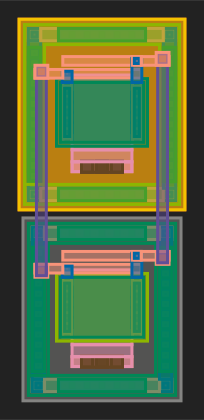

<ipython-input-11-8de5b00d4abb>:18: UserWarning: Unnamed cells, 2 in 'TG$2'
  transmissionGate_cell(pdk=sky130, width=2, length=2).write_gds("transmissionGate.gds")
2024-09-03 02:07:27.913 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'transmissionGate.gds'


In [11]:
import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output

def display_gds(gds_file, scale = 3):
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg('out.svg')
  # Scale the image for displaying
  fig = sg.fromfile('out.svg')
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save('out.svg')

  # Display the image
  IPython.display.display(IPython.display.SVG('out.svg'))

  transmissionGate_cell(pdk=sky130, width=2, length=2).write_gds("transmissionGate.gds")
display_gds("transmissionGate.gds")


Geminiによると・・・
生成されたGDSファイルに名前のないセルがあるという警告が表示されているようです。この警告はgdsfactoryから発生し、「TG$2」セル内に明示的な名前が割り当てられていないコンポーネントがあることを示しています。

すぐに問題が発生するわけではありませんが、整理とデバッグを改善するために、すべてのコンポーネントに名前を付けることをお勧めします。コンポーネントを作成するときに name 引数を指定することで、コンポーネントに名前を付けることができます。

たとえば、transmissionGate_cell 関数では、pfet および nfet インスタンスに名前を付けることができます。


pfet = pmos(pdk=pdk, with_substrate_tap=False, with_dummy=(False, False), width=width, length=length, name="pmos_instance")
nfet = nmos(pdk=pdk, with_substrate_tap=False, with_dummy=(False, False), width=width, length=length, name="nmos_instance")
Use code with caution
これにより、GDSファイルがより読みやすくなり、扱いやすくなります。

・・・らしいです